In [1]:
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import TripletMarginLoss
from tqdm import tqdm
import torchvision.transforms as transforms
import torch.nn as nn
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import scipy.io
from PIL import Image
from sklearn.metrics import precision_score, recall_score
from torchvision.models.inception import InceptionOutputs
import faiss
from sklearn.manifold import TSNE

device = 'cuda'

### Загрузка модели

In [3]:
model = models.inception_v3(pretrained=True)
model.train()
model = model.to(device)

C:\Users\baben_bakg1j1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\baben_bakg1j1\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
ANNOTATION_PATH = 'data/devkit/cars_train_annos.mat'
META_PATH = 'data/devkit/cars_meta.mat'
TRAIN_IMG_PATH = 'data/cars_train/cars_train'
TEST_IMG_PATH = 'data/cars_test/cars_test'

mat = scipy.io.loadmat(ANNOTATION_PATH)
fname_to_class = {fname: cl-1 for fname, cl in zip(
    [i[0] for i in mat['annotations'][0]['fname']], 
    [i[0][0] for i in mat['annotations'][0]['class']]
)}

cars_meta = scipy.io.loadmat(META_PATH)
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

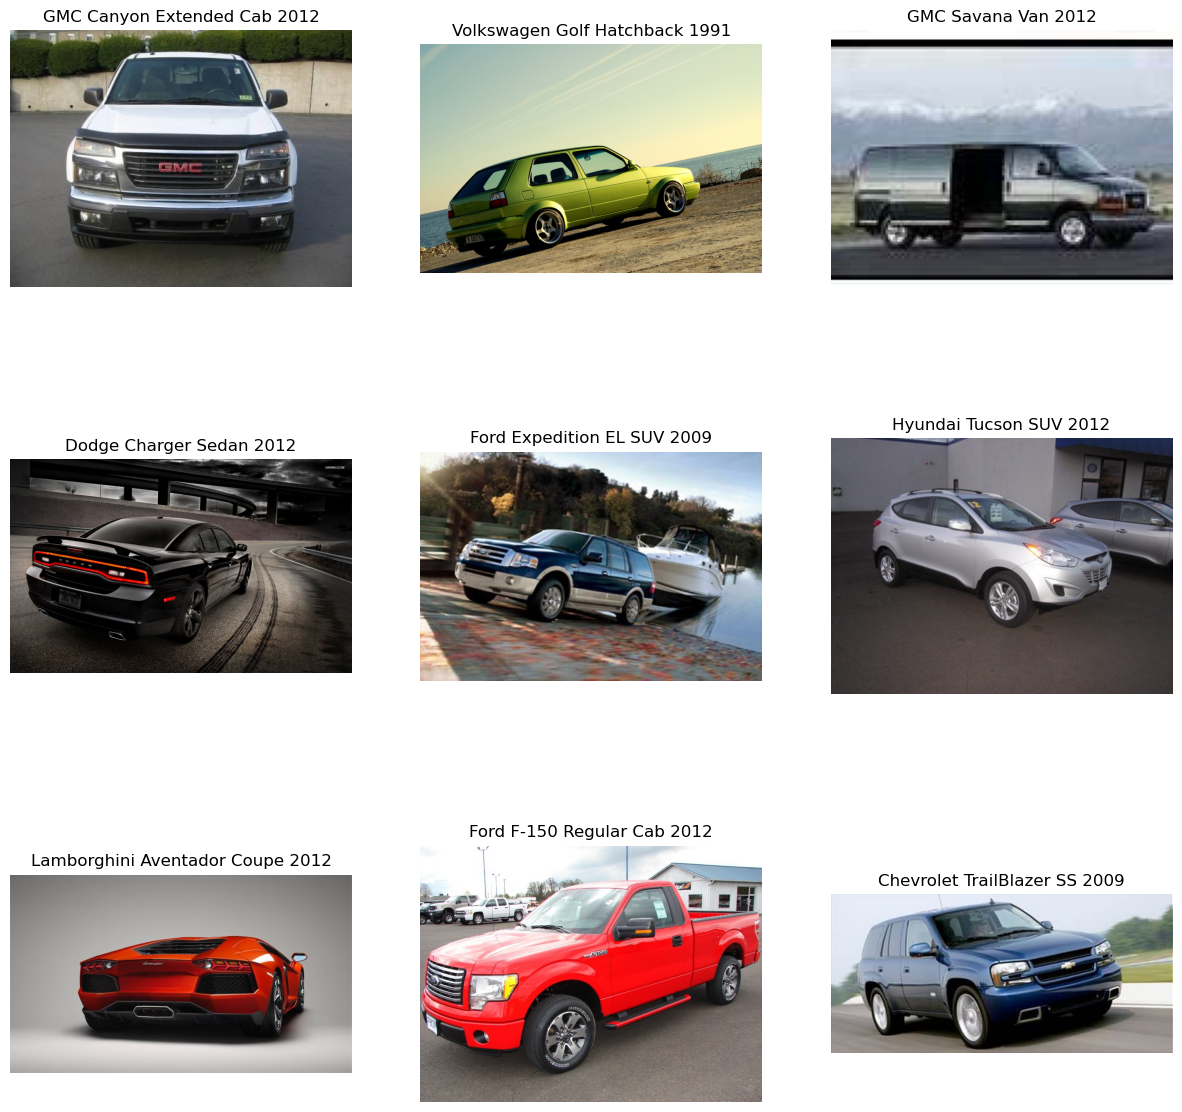

In [5]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize=(15, 15))
for idx, im_idx in enumerate(random.sample(range(len(fname_to_class)), num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(TRAIN_IMG_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')
plt.show()

### Реалзация Dataset и Dataloader и аугментаций

In [7]:
def get_transformations():
    return transforms.Compose([
        transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),  
        transforms.RandomHorizontalFlip(),                     
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
        transforms.RandomRotation(degrees=15),                
        transforms.ToTensor(),                                 
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
    ])
    
class CarDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None, subset_fraction=0.1):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        self.image_files = list(annotations.keys())
        self.classes = list(set(annotations.values()))

        self.class_to_images = {cl: [] for cl in self.classes}
        for fname, cl in annotations.items():
            self.class_to_images[cl].append(fname)

        self.image_files = random.sample(self.image_files, int(len(self.image_files) * subset_fraction))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        anchor_file = self.image_files[idx]
        anchor_class = self.annotations[anchor_file]

        anchor_image = Image.open(os.path.join(self.image_dir, anchor_file)).convert('RGB')

        positive_file = random.choice(self.class_to_images[anchor_class])
        positive_image = Image.open(os.path.join(self.image_dir, positive_file)).convert('RGB')

        negative_class = random.choice([cl for cl in self.classes if cl != anchor_class])
        negative_file = random.choice(self.class_to_images[negative_class])
        negative_image = Image.open(os.path.join(self.image_dir, negative_file)).convert('RGB')

        if self.transform:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image, positive_image, negative_image

class InceptionV3Embedding(nn.Module):
    def __init__(self, model, embedding_dim=128):
        super(InceptionV3Embedding, self).__init__()
        self.base_model = model
        self.base_model.fc = nn.Identity()  

        self.embedding_layer = nn.Linear(2048, embedding_dim)  

    def forward(self, x):
        x = self.base_model(x)  
        x = x[0] if isinstance(x, tuple) else x
        x = self.embedding_layer(x)  
        return x

transform = transforms.Compose([
    transforms.Resize(320),        
    transforms.CenterCrop(299),    
    transforms.ToTensor()
])

train_dataset = CarDataset(
    image_dir=TRAIN_IMG_PATH,
    annotations=fname_to_class,
    transform=transform,
    subset_fraction=0.5
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=True
)

train_loader_no_augmentations = DataLoader(
    CarDataset(
        image_dir=TRAIN_IMG_PATH,
        annotations=fname_to_class,
        transform=transform,
        subset_fraction=0.5
    ),
    batch_size=16,
    shuffle=True,
    pin_memory=True
)

train_loader_with_augmentations = DataLoader(
    CarDataset(
        image_dir=TRAIN_IMG_PATH,
        annotations=fname_to_class,
        transform=get_transformations(),
        subset_fraction=0.5
    ),
    batch_size=16,
    shuffle=True,
    pin_memory=True
)

base_model = models.inception_v3(pretrained=True)
embedding_dim = 128
model = InceptionV3Embedding(base_model, embedding_dim=embedding_dim).to(device)
model.train()

print("Output shape without augmentations:")
for anchor, positive, negative in train_loader_no_augmentations:
    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
    with torch.no_grad():
        output = model(anchor)
    print("Output shape:", output.shape)  
    break

print("Output shape with augmentations:")
for anchor, positive, negative in train_loader_with_augmentations:
    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
    with torch.no_grad():
        output = model(anchor)
    print("Output shape:", output.shape)  
    break

Output shape without augmentations:
Output shape: torch.Size([16, 128])
Output shape with augmentations:
Output shape: torch.Size([16, 128])


### train-loop и обучение с Triplet loss

In [9]:
def train_model(model, train_loader, num_epochs=10, lr=0.0001, margin=1.0):
    model.to(device)
    
    triplet_loss_fn = TripletMarginLoss(margin=margin, p=2).to(device)  
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()  
        epoch_loss = 0

        for anchor, positive, negative in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)
            
            loss = triplet_loss_fn(anchor_embedding, positive_embedding, negative_embedding)
            
            optimizer.zero_grad()  
            loss.backward()  
            optimizer.step()  
            
            epoch_loss += loss.item()  

        avg_loss = epoch_loss / len(train_loader) 
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

In [16]:
train_model(model, train_loader, num_epochs=10, lr=0.1, margin=2.0)

Epoch 1/10: 100%|████████████████████████████████████████████████████████████████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch [1/10], Loss: 16.2178


Epoch 2/10: 100%|████████████████████████████████████████████████████████████████████| 255/255 [03:01<00:00,  1.40it/s]


Epoch [2/10], Loss: 2.5420


Epoch 3/10: 100%|████████████████████████████████████████████████████████████████████| 255/255 [03:04<00:00,  1.38it/s]


Epoch [3/10], Loss: 1.9497


Epoch 4/10: 100%|████████████████████████████████████████████████████████████████████| 255/255 [03:01<00:00,  1.40it/s]


Epoch [4/10], Loss: 1.9660


Epoch 5/10: 100%|████████████████████████████████████████████████████████████████████| 255/255 [03:02<00:00,  1.39it/s]


Epoch [5/10], Loss: 1.9793


Epoch 6/10: 100%|████████████████████████████████████████████████████████████████████| 255/255 [03:00<00:00,  1.41it/s]


Epoch [6/10], Loss: 1.9800


Epoch 7/10: 100%|████████████████████████████████████████████████████████████████████| 255/255 [03:01<00:00,  1.41it/s]


Epoch [7/10], Loss: 1.9768


Epoch 8/10: 100%|████████████████████████████████████████████████████████████████████| 255/255 [03:02<00:00,  1.40it/s]


Epoch [8/10], Loss: 2.1781


Epoch 9/10: 100%|████████████████████████████████████████████████████████████████████| 255/255 [03:01<00:00,  1.40it/s]


Epoch [9/10], Loss: 2.0138


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████████| 255/255 [03:01<00:00,  1.40it/s]

Epoch [10/10], Loss: 2.0067


In [11]:
train_model(model, train_loader_with_augmentations, num_epochs=6, lr=0.05, margin=0.5)

Epoch 1/6: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [04:58<00:00,  1.17s/it]


Epoch [1/6], Loss: 6.0424


Epoch 2/6: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [04:56<00:00,  1.16s/it]


Epoch [2/6], Loss: 0.8622


Epoch 3/6: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [05:02<00:00,  1.18s/it]


Epoch [3/6], Loss: 0.5045


Epoch 4/6: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [04:56<00:00,  1.16s/it]


Epoch [4/6], Loss: 0.5039


Epoch 5/6: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [05:00<00:00,  1.18s/it]


Epoch [5/6], Loss: 0.5011


Epoch 6/6: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [04:58<00:00,  1.17s/it]

Epoch [6/6], Loss: 0.5037


### Другие функции потерь

In [22]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        distance = F.pairwise_distance(output1, output2)
        loss = (1 - label) * torch.pow(distance, 2) + (label) * torch.pow(torch.clamp(self.margin - distance, min=0.0), 2)
        return torch.mean(loss)

class AngularMarginLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(AngularMarginLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        anchor_norm = F.normalize(anchor)
        positive_norm = F.normalize(positive)
        negative_norm = F.normalize(negative)

        pos_sim = torch.acos((anchor_norm * positive_norm).sum(dim=1))
        neg_sim = torch.acos((anchor_norm * negative_norm).sum(dim=1))

        loss = F.relu(pos_sim + self.margin - neg_sim)
        return loss.mean()

class CircleLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(CircleLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)

        loss = torch.clamp(pos_dist - neg_dist + self.margin, min=0)
        return loss.mean()

### Обучение с ContrastiveLoss

In [24]:
def train_model_contrastive(model, train_loader, num_epochs=10, lr=0.0001):
    model.to(device)
    
    contrastive_loss_fn = ContrastiveLoss(margin=1.0).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0

        for anchor, positive, negative in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
            
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)

            labels_pos = torch.ones(anchor.size(0)).to(device)
            labels_neg = torch.zeros(anchor.size(0)).to(device)

            loss_pos = contrastive_loss_fn(anchor_embedding, positive_embedding, labels_pos)
            loss_neg = contrastive_loss_fn(anchor_embedding, negative_embedding, labels_neg)

            loss = loss_pos + loss_neg

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


In [22]:
train_model_contrastive(model, train_loader, num_epochs=5, lr=0.05)

Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [03:08<00:00,  1.35it/s]


Epoch [1/5], Loss: 1.0000


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [03:07<00:00,  1.36it/s]


Epoch [2/5], Loss: 1.0000


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [03:12<00:00,  1.33it/s]


Epoch [3/5], Loss: 1.0000


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [03:13<00:00,  1.32it/s]


Epoch [4/5], Loss: 1.0000


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 255/255 [03:09<00:00,  1.34it/s]

Epoch [5/5], Loss: 1.0000


### Функции для оценки качества моделей

In [26]:
def get_embeddings(data_loader, model):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for anchor, positive, negative in data_loader:
            anchor = anchor.to(device)
            embedding = model(anchor)
            embeddings.append(embedding.cpu().numpy())
    return np.vstack(embeddings) 

def filter_annotations(image_dir, annotations):
    return {fname: cls for fname, cls in annotations.items() if os.path.isfile(os.path.join(image_dir, fname))}


def build_faiss_index(train_embeddings):
    dim = train_embeddings.shape[1]  
    index = faiss.IndexFlatL2(dim)   
    index.add(train_embeddings)
    return index

def compute_metrics(index, test_embeddings, test_labels, train_labels, k_values=[1, 5]):
    D, I = index.search(test_embeddings, max(k_values)) 

    results = {}
    for k in k_values:
        top_k_predictions = I[:, :k]
        top_k_labels = train_labels[top_k_predictions]

        recall_at_k = np.mean([
            1 if test_labels[i] in top_k_labels[i] else 0 
            for i in range(len(test_labels))
        ])
        
        precision_at_k = np.mean([
            np.sum(top_k_labels[i] == test_labels[i]) / k
            for i in range(len(test_labels))
        ])

        results[f'Recall@{k}'] = recall_at_k
        results[f'Precision@{k}'] = precision_at_k

    return results

### Оценка качества

In [29]:
filtered_test_annotations = filter_annotations(TEST_IMG_PATH, fname_to_class)

test_dataset = CarDataset(
    image_dir=TEST_IMG_PATH,
    annotations=filtered_test_annotations,
    transform=transform,
    subset_fraction=0.5
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=True
)

In [31]:
train_embeddings = get_embeddings(train_loader, model)
test_embeddings = get_embeddings(test_loader, model)

train_labels = np.array([fname_to_class[img_file] for img_file in train_dataset.image_files])
test_labels = np.array([fname_to_class[img_file] for img_file in test_dataset.image_files])

index = build_faiss_index(train_embeddings)

metrics = compute_metrics(index, test_embeddings, test_labels, train_labels, k_values=[1, 5])

In [32]:
metrics

{'Recall@1': 0.004975124378109453,
 'Precision@1': 0.004975124378109453,
 'Recall@5': 0.024875621890547265,
 'Precision@5': 0.004975124378109453}

In [ ]:
{'Recall@1': 0.006218905472636816,
 'Precision@1': 0.006218905472636816,
 'Recall@5': 0.026119402985074626,
 'Precision@5': 0.0052238805970149255}

In [ ]:
{'Recall@1': 0.004975124378109453,
 'Precision@1': 0.004975124378109453,
 'Recall@5': 0.017412935323383085,
 'Precision@5': 0.0034825870646766175}

In [ ]:
{'Recall@1': 0.006218905472636816,
 'Precision@1': 0.006218905472636816,
 'Recall@5': 0.033582089552238806,
 'Precision@5': 0.006965174129353233}

In [ ]:
{'Recall@1': 0.006218905472636816,
 'Precision@1': 0.006218905472636816,
 'Recall@5': 0.021144278606965175,
 'Precision@5': 0.004228855721393036}

### Визуализация работы

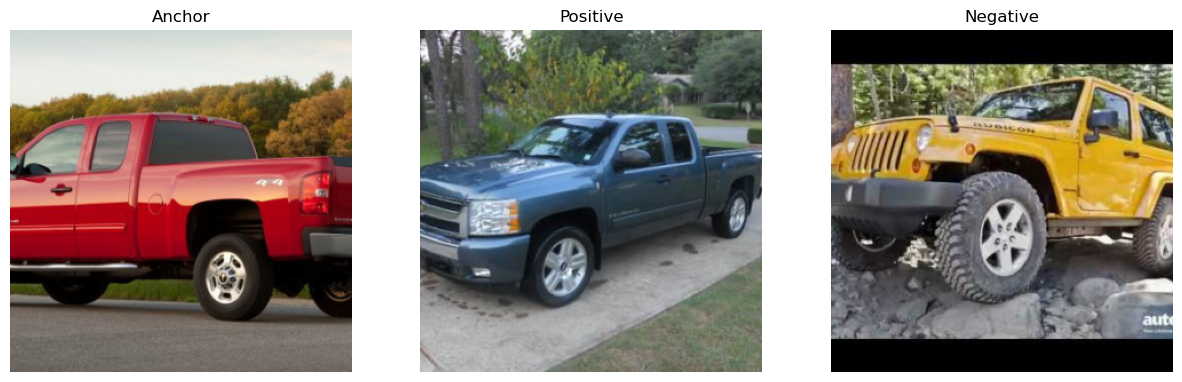

In [74]:
def show_images(images, titles=None):
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
    plt.show()

def visualize_data_loader(data_loader, model, device):
    for anchor, positive, negative in data_loader:
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        with torch.no_grad():
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)

        show_images([anchor[0], positive[0], negative[0]], titles=["Anchor", "Positive", "Negative"])
        break  

visualize_data_loader(train_loader, model, device)

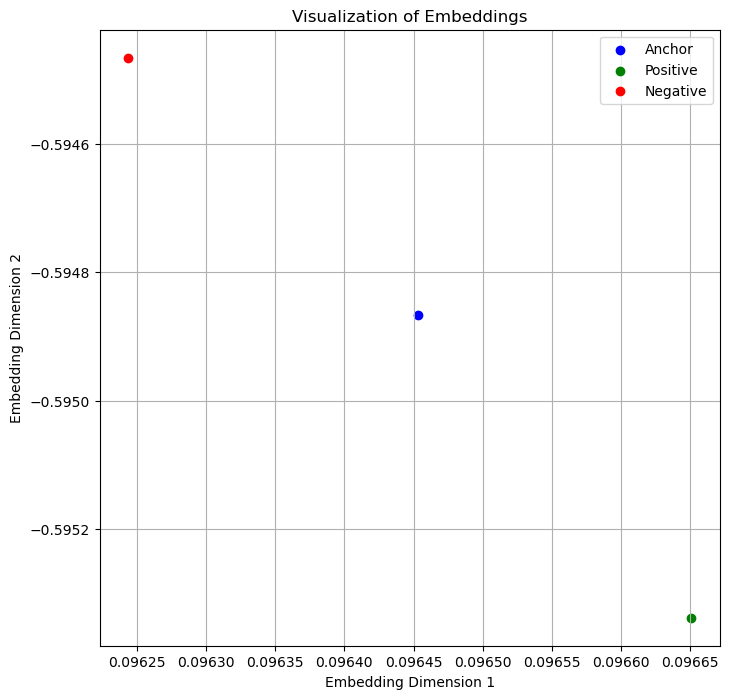

In [82]:
def visualize_embeddings(anchor, positive, negative, model, device):
    with torch.no_grad():
        anchor_embedding = model(anchor.unsqueeze(0).to(device))
        positive_embedding = model(positive.unsqueeze(0).to(device))
        negative_embedding = model(negative.unsqueeze(0).to(device))

    anchor_emb = anchor_embedding.cpu().numpy().flatten()
    positive_emb = positive_embedding.cpu().numpy().flatten()
    negative_emb = negative_embedding.cpu().numpy().flatten()

    plt.figure(figsize=(8, 8))
    plt.scatter(anchor_emb[0], anchor_emb[1], color='blue', label='Anchor')
    plt.scatter(positive_emb[0], positive_emb[1], color='green', label='Positive')
    plt.scatter(negative_emb[0], negative_emb[1], color='red', label='Negative')

    plt.title('Visualization of Embeddings')
    plt.xlabel('Embedding Dimension 1')
    plt.ylabel('Embedding Dimension 2')
    plt.legend()
    plt.grid()
    plt.show()

for anchor, positive, negative in train_loader:
    visualize_embeddings(anchor[0], positive[0], negative[0], model, device)
    break  

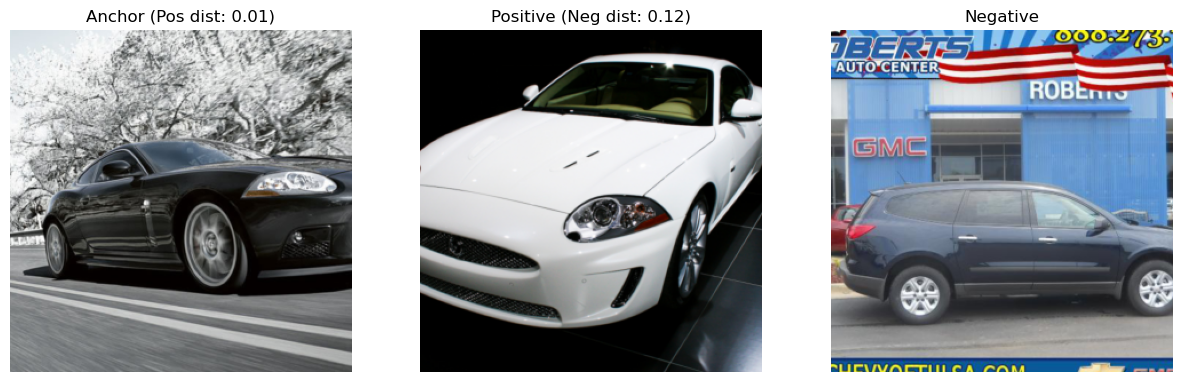

In [84]:
def visualize_predictions(anchor, positive, negative, model, device):
    with torch.no_grad():
        anchor_embedding = model(anchor.unsqueeze(0).to(device))
        positive_embedding = model(positive.unsqueeze(0).to(device))
        negative_embedding = model(negative.unsqueeze(0).to(device))

    pos_distance = F.pairwise_distance(anchor_embedding, positive_embedding).item()
    neg_distance = F.pairwise_distance(anchor_embedding, negative_embedding).item()

    show_images([anchor, positive, negative], titles=[
        f"Anchor (Pos dist: {pos_distance:.2f})", 
        f"Positive (Neg dist: {neg_distance:.2f})", 
        f"Negative"
    ])

for anchor, positive, negative in train_loader:
    visualize_predictions(anchor[0], positive[0], negative[0], model, device)
    break  